# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os

#from scipy.misc import imread, imresize
from imageio import  imread
from PIL import Image  

import datetime
import glob

#from tqdm.autonotebook import tqdm
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
#!pip show tensorflow

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('train.csv').readlines()) #List of all training videos
val_doc = np.random.permutation(open('val.csv').readlines())  #List of all validation videos
batch_size = 40 #experiment with the batch size. Number of videos in each batch
imsize=(128,128)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
#delete old resized file. Trying with different size of image. 
#If old size does not work then we need to remove those thousands of files
def delete_old_files(folders, path):
    for folder in folders:
        fileList = glob.glob(path +"/"+folder.split(";")[0]+"/rs_*" )
        for f in fileList:
            try:
                os.remove(f)
            except:
                print("Error while deleting file : ", f)
            print ("Deleting ",f)
        
#delete_old_files(train_doc, "train")
#delete_old_files(val_doc, "val")

In [6]:
#Resize all image and keep them on disk so that for we need not to do this in memory for every epoch
from tqdm.autonotebook import tqdm
def resize_images(source_path):
    folders = os.listdir(source_path)
    for i in tqdm( range(0, len(folders))):
        folder=folders[i]
        imgs = os.listdir(source_path+'/'+ folder) #.split(';')[0]) # read all the images in the folder
        for img in imgs:
            if (img,img[0:3])!="rs_":
                img_file = source_path+'/'+folder +"/"+img
                rs_img_file = source_path+'/'+folder+'/rs_'+img
                image = Image.open(img_file)
                
                left  = int((image.width*0.05)/2)
                right = image.width-2*left
                top   =  int((image.height*0.05)/2)
                bottom = image.height- 2*top
                
                image = image.crop((left, top, right, bottom)) 
                image = image.resize(imsize)
                
                image.save(rs_img_file)
                print("Resizing: ",rs_img_file)
        
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'

train_path = 'train'
val_path   = 'val'

#resize_images(train_path)
#resize_images(val_path)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
img_idx = np.array( range(0,30,3))
imgs_from_1video=len(img_idx) #Number of Images from each video

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:  
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        remaining_videos= len(t)%batch_size
 
        for batch in tqdm( range(num_batches) ): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, imgs_from_1video ,imsize[0] , imsize[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in              
                    if imgs[item][0:3]=="rs_":
                        img_file = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                        image = imread(img_file).astype(np.float32)

                        batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if remaining_videos!=0:      
            batch_data   = np.zeros((remaining_videos, imgs_from_1video ,imsize[0] , imsize[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_videos,5)) # batch_labels is the one hot representation of the output
            
            for i in range(remaining_videos):
                    folder= i + batch*batch_size + 1
                    imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder

                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                        if imgs[item][0:3]=="rs_":
                            img_file = source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]
                            image = imread(img_file).astype(np.float32)
                            
                            batch_data[i,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                            batch_data[i,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                            batch_data[i,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                            
                    batch_labels[i, int(t[folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
# model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
# model.compile(loss='categorical_crossentropy',optimizer='SGD',
#               metrics=['accuracy'])
# training_generator = AugmentedDataGenerator('train', ablation=5)
# validation_generator = AugmentedDataGenerator('val', ablation=5)


## Commenting Conv3D Model

num_classes=5

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

model = Sequential()
model.add(Conv3D(32, (2, 3, 3), padding='same',
                 input_shape=(imgs_from_1video, imsize[0],imsize[1],3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, (2, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))


model.add(Conv3D(64, (2, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(64, (2, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))


model.add(Conv3D(128, (2, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(128, (2, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))
#write your model here

## CNN + RNN Model

In [ ]:
num_classes=5

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.regularizers import l2

model = Sequential()

#### Set1
model.add(Convolution2D(32, 3, 3, border_mode='same',
                 input_shape=(imsize[0],imsize[1],3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(32, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#### Set2
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


#### Set3
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, W_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(num_classes, W_regularizer=l2(0.1), activation='softmax')))

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = "adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 128, 128, 32)  1760      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 128, 128, 32)  128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 128, 128, 32)  18464     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 64, 64, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list = []


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 40
Source path =  train ; batch size = 40
Epoch 1/25


 7/17 [===========>..................] - ETA: 1:38 - loss: 2.1380 - categorical_accuracy: 0.2929

16/17 [===========================>..] - ETA: 6s - loss: 1.8394 - categorical_accuracy: 0.3875 


17/17 [==============================] - 108s 6s/step - loss: 1.8225 - categorical_accuracy: 0.3877 - val_loss: 2.6008 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-02-2702_37_59.697121/model-00001-1.82922-0.38763-2.60076-0.46000.h5
Epoch 2/25
 7/17 [===========>..................] - ETA: 31s - loss: 1.4632 - categorical_accuracy: 0.4821

16/17 [===========================>..] - ETA: 3s - loss: 1.3985 - categorical_accuracy: 0.4750


17/17 [==============================] - 54s 3s/step - loss: 1.4007 - categorical_accuracy: 0.4752 - val_loss: 1.7973 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-02-2702_37_59.697121/model-00002-1.39981-0.47511-1.79727-0.49000.h5
Epoch 3/25
 7/17 [===========>..................] - ETA: 30s - loss: 1.2900 - categorical_accuracy: 0.4893

16/17 [===========================>..] - ETA: 3s - loss: 1.2528 - categorical_accuracy: 0.5141


17/17 [==============================] - 54s 3s/step - loss: 1.2443 - categorical_accuracy: 0.5120 - val_loss: 4.6670 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2020-02-2702_37_59.697121/model-00003-1.24764-0.51282-4.66705-0.43000.h5
Epoch 4/25
 7/17 [===========>..................] - ETA: 31s - loss: 1.1906 - categorical_accuracy: 0.5536

16/17 [===========================>..] - ETA: 3s - loss: 1.1853 - categorical_accuracy: 0.5641


17/17 [==============================] - 54s 3s/step - loss: 1.1609 - categorical_accuracy: 0.5741 - val_loss: 2.3707 - val_categorical_accuracy: 0.4300

Epoch 00004: saving model to model_init_2020-02-2702_37_59.697121/model-00004-1.17053-0.57014-2.37067-0.43000.h5
Epoch 5/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.9254 - categorical_accuracy: 0.6464

16/17 [===========================>..] - ETA: 3s - loss: 0.9348 - categorical_accuracy: 0.6422


17/17 [==============================] - 54s 3s/step - loss: 0.9371 - categorical_accuracy: 0.6403 - val_loss: 5.7088 - val_categorical_accuracy: 0.3500

Epoch 00005: saving model to model_init_2020-02-2702_37_59.697121/model-00005-0.93617-0.64103-5.70875-0.35000.h5
Epoch 6/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.7655 - categorical_accuracy: 0.6929

16/17 [===========================>..] - ETA: 3s - loss: 0.8330 - categorical_accuracy: 0.6797


17/17 [==============================] - 54s 3s/step - loss: 0.8191 - categorical_accuracy: 0.6881 - val_loss: 3.3892 - val_categorical_accuracy: 0.3200

Epoch 00006: saving model to model_init_2020-02-2702_37_59.697121/model-00006-0.82458-0.68477-3.38916-0.32000.h5
Epoch 7/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.7306 - categorical_accuracy: 0.7500

16/17 [===========================>..] - ETA: 3s - loss: 0.7044 - categorical_accuracy: 0.7484


17/17 [==============================] - 54s 3s/step - loss: 0.6855 - categorical_accuracy: 0.7604 - val_loss: 1.5893 - val_categorical_accuracy: 0.5500

Epoch 00007: saving model to model_init_2020-02-2702_37_59.697121/model-00007-0.69300-0.75566-1.58925-0.55000.h5
Epoch 8/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.5274 - categorical_accuracy: 0.8321

16/17 [===========================>..] - ETA: 3s - loss: 0.5565 - categorical_accuracy: 0.8063


17/17 [==============================] - 54s 3s/step - loss: 0.5518 - categorical_accuracy: 0.8049 - val_loss: 1.7575 - val_categorical_accuracy: 0.4600

Epoch 00008: saving model to model_init_2020-02-2702_37_59.697121/model-00008-0.55366-0.80543-1.75752-0.46000.h5
Epoch 9/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.4463 - categorical_accuracy: 0.8286

16/17 [===========================>..] - ETA: 3s - loss: 0.4178 - categorical_accuracy: 0.8438


17/17 [==============================] - 54s 3s/step - loss: 0.4131 - categorical_accuracy: 0.8452 - val_loss: 1.0540 - val_categorical_accuracy: 0.5500

Epoch 00009: saving model to model_init_2020-02-2702_37_59.697121/model-00009-0.41494-0.84465-1.05397-0.55000.h5
Epoch 10/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.3679 - categorical_accuracy: 0.8571

16/17 [===========================>..] - ETA: 3s - loss: 0.3434 - categorical_accuracy: 0.8641


17/17 [==============================] - 54s 3s/step - loss: 0.3471 - categorical_accuracy: 0.8619 - val_loss: 1.1791 - val_categorical_accuracy: 0.6300

Epoch 00010: saving model to model_init_2020-02-2702_37_59.697121/model-00010-0.34567-0.86275-1.17906-0.63000.h5
Epoch 11/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.2812 - categorical_accuracy: 0.9107

16/17 [===========================>..] - ETA: 3s - loss: 0.2266 - categorical_accuracy: 0.9250


17/17 [==============================] - 54s 3s/step - loss: 0.2335 - categorical_accuracy: 0.9218 - val_loss: 1.4753 - val_categorical_accuracy: 0.5400

Epoch 00011: saving model to model_init_2020-02-2702_37_59.697121/model-00011-0.23075-0.92308-1.47525-0.54000.h5
Epoch 12/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.1886 - categorical_accuracy: 0.9250

16/17 [===========================>..] - ETA: 3s - loss: 0.1865 - categorical_accuracy: 0.9281


17/17 [==============================] - 54s 3s/step - loss: 0.1788 - categorical_accuracy: 0.9323 - val_loss: 1.3788 - val_categorical_accuracy: 0.5400

Epoch 00012: saving model to model_init_2020-02-2702_37_59.697121/model-00012-0.18187-0.93062-1.37879-0.54000.h5
Epoch 13/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.1065 - categorical_accuracy: 0.9750

16/17 [===========================>..] - ETA: 3s - loss: 0.1282 - categorical_accuracy: 0.9609


17/17 [==============================] - 54s 3s/step - loss: 0.1308 - categorical_accuracy: 0.9632 - val_loss: 1.2687 - val_categorical_accuracy: 0.5600

Epoch 00013: saving model to model_init_2020-02-2702_37_59.697121/model-00013-0.12975-0.96229-1.26872-0.56000.h5
Epoch 14/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0818 - categorical_accuracy: 0.9786

16/17 [===========================>..] - ETA: 3s - loss: 0.1112 - categorical_accuracy: 0.9625


17/17 [==============================] - 54s 3s/step - loss: 0.1072 - categorical_accuracy: 0.9647 - val_loss: 1.3019 - val_categorical_accuracy: 0.5700

Epoch 00014: saving model to model_init_2020-02-2702_37_59.697121/model-00014-0.10876-0.96380-1.30195-0.57000.h5
Epoch 15/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0915 - categorical_accuracy: 0.9714

16/17 [===========================>..] - ETA: 3s - loss: 0.0924 - categorical_accuracy: 0.9719


17/17 [==============================] - 54s 3s/step - loss: 0.0929 - categorical_accuracy: 0.9710 - val_loss: 1.3236 - val_categorical_accuracy: 0.6300

Epoch 00015: saving model to model_init_2020-02-2702_37_59.697121/model-00015-0.09273-0.97134-1.32363-0.63000.h5
Epoch 16/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.1183 - categorical_accuracy: 0.9464

16/17 [===========================>..] - ETA: 3s - loss: 0.1046 - categorical_accuracy: 0.9594


17/17 [==============================] - 54s 3s/step - loss: 0.1029 - categorical_accuracy: 0.9617 - val_loss: 1.1233 - val_categorical_accuracy: 0.6700

Epoch 00016: saving model to model_init_2020-02-2702_37_59.697121/model-00016-0.10359-0.96078-1.12329-0.67000.h5
Epoch 17/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0594 - categorical_accuracy: 0.9786

16/17 [===========================>..] - ETA: 3s - loss: 0.0875 - categorical_accuracy: 0.9703


17/17 [==============================] - 54s 3s/step - loss: 0.0836 - categorical_accuracy: 0.9720 - val_loss: 1.1119 - val_categorical_accuracy: 0.6300

Epoch 00017: saving model to model_init_2020-02-2702_37_59.697121/model-00017-0.08516-0.97134-1.11186-0.63000.h5
Epoch 18/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0430 - categorical_accuracy: 0.9929

16/17 [===========================>..] - ETA: 3s - loss: 0.0507 - categorical_accuracy: 0.9891


17/17 [==============================] - 54s 3s/step - loss: 0.0490 - categorical_accuracy: 0.9897 - val_loss: 1.1384 - val_categorical_accuracy: 0.6800

Epoch 00018: saving model to model_init_2020-02-2702_37_59.697121/model-00018-0.04968-0.98944-1.13843-0.68000.h5
Epoch 19/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0523 - categorical_accuracy: 0.9929

16/17 [===========================>..] - ETA: 3s - loss: 0.0553 - categorical_accuracy: 0.9906


17/17 [==============================] - 54s 3s/step - loss: 0.0603 - categorical_accuracy: 0.9887 - val_loss: 2.2417 - val_categorical_accuracy: 0.6300

Epoch 00019: saving model to model_init_2020-02-2702_37_59.697121/model-00019-0.05828-0.98944-2.24168-0.63000.h5
Epoch 20/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.1673 - categorical_accuracy: 0.9571

16/17 [===========================>..] - ETA: 3s - loss: 0.1317 - categorical_accuracy: 0.9656


17/17 [==============================] - 54s 3s/step - loss: 0.1311 - categorical_accuracy: 0.9651 - val_loss: 1.6547 - val_categorical_accuracy: 0.6200

Epoch 00020: saving model to model_init_2020-02-2702_37_59.697121/model-00020-0.13134-0.96531-1.65470-0.62000.h5
Epoch 21/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0822 - categorical_accuracy: 0.9714

16/17 [===========================>..] - ETA: 3s - loss: 0.0764 - categorical_accuracy: 0.9781


17/17 [==============================] - 54s 3s/step - loss: 0.0770 - categorical_accuracy: 0.9769 - val_loss: 1.6657 - val_categorical_accuracy: 0.6200

Epoch 00021: saving model to model_init_2020-02-2702_37_59.697121/model-00021-0.07674-0.97738-1.66565-0.62000.h5
Epoch 22/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0348 - categorical_accuracy: 0.9929

16/17 [===========================>..] - ETA: 3s - loss: 0.0475 - categorical_accuracy: 0.9922


17/17 [==============================] - 54s 3s/step - loss: 0.0505 - categorical_accuracy: 0.9901 - val_loss: 1.0406 - val_categorical_accuracy: 0.7300

Epoch 00022: saving model to model_init_2020-02-2702_37_59.697121/model-00022-0.04930-0.99095-1.04060-0.73000.h5
Epoch 23/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0478 - categorical_accuracy: 0.9929

16/17 [===========================>..] - ETA: 3s - loss: 0.0342 - categorical_accuracy: 0.9953


17/17 [==============================] - 54s 3s/step - loss: 0.0367 - categorical_accuracy: 0.9931 - val_loss: 1.1382 - val_categorical_accuracy: 0.6600

Epoch 00023: saving model to model_init_2020-02-2702_37_59.697121/model-00023-0.03572-0.99397-1.13820-0.66000.h5
Epoch 24/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0268 - categorical_accuracy: 1.0000

16/17 [===========================>..] - ETA: 3s - loss: 0.0346 - categorical_accuracy: 0.9953


17/17 [==============================] - 54s 3s/step - loss: 0.0350 - categorical_accuracy: 0.9956 - val_loss: 0.8638 - val_categorical_accuracy: 0.7000

Epoch 00024: saving model to model_init_2020-02-2702_37_59.697121/model-00024-0.03480-0.99548-0.86385-0.70000.h5
Epoch 25/25
 7/17 [===========>..................] - ETA: 30s - loss: 0.0264 - categorical_accuracy: 0.9929

16/17 [===========================>..] - ETA: 3s - loss: 0.0278 - categorical_accuracy: 0.9922


17/17 [==============================] - 54s 3s/step - loss: 0.0279 - categorical_accuracy: 0.9926 - val_loss: 1.0565 - val_categorical_accuracy: 0.6500

Epoch 00025: saving model to model_init_2020-02-2702_37_59.697121/model-00025-0.02784-0.99246-1.05654-0.65000.h5


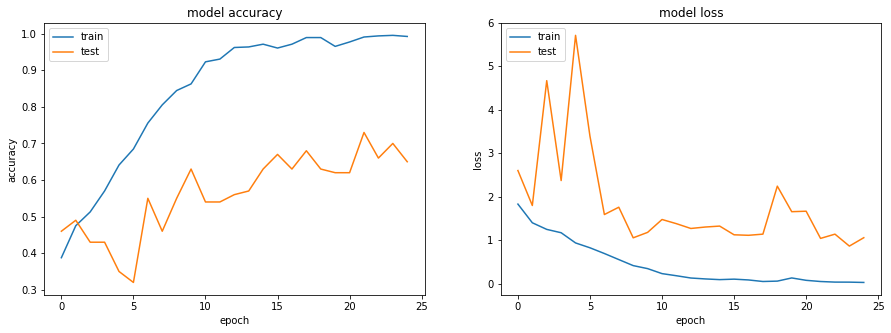

In [16]:
# summarize history for accuracy
fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()